In [47]:
# All Package Imports
import os
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
warnings.filterwarnings("ignore")

# import sklearn packages for modelling
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import gc

%matplotlib inline

In [3]:
# loading datasets
train_data = pd.read_csv("dataset/application_train.csv")
test_data = pd.read_csv("dataset/application_test.csv")

Based on EDA_report.html and analysis we need to (as a preprocessing step):
  - Handle missing values.
  - Drop non importante columns.
  - Fix outliers.
  - Encoding categorical variables.
  - Feature Engineer some features.
  - Fit initial models with and without features.
  - Test a final model.

In [4]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in train_data:
    if train_data[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(train_data[col].unique())) <= 2:
            print("{} was encoded".format(col))
            # Train on the training data
            le.fit(train_data[col])
            # Transform both training and testing data
            train_data[col] = le.transform(train_data[col])
            test_data[col] = le.transform(test_data[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

NAME_CONTRACT_TYPE was encoded
FLAG_OWN_CAR was encoded
FLAG_OWN_REALTY was encoded
3 columns were label encoded.


In [5]:
# one-hot encoding of categorical variables
train_data = pd.get_dummies(train_data)
test_data = pd.get_dummies(test_data)

print('Training Features shape: ', train_data.shape)
print('Testing Features shape: ', test_data.shape)
train_labels = train_data['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
train_data, test_data = train_data.align(test_data, join = 'inner', axis = 1)

# Add the target back in
train_data['TARGET'] = train_labels
print('Aligned Training Features shape: ', train_data.shape)
print('Aligned Testing Features shape: ', test_data.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)
Aligned Training Features shape:  (307511, 240)
Aligned Testing Features shape:  (48744, 239)


In [31]:
# create X_train, y_train
X_train = train_data.drop('TARGET', axis = 1)
y_train = train_data['TARGET']
X_test = test_data

X_train = X_train.drop('SK_ID_CURR', axis = 1)
X_test = X_test.drop('SK_ID_CURR', axis = 1)

features = list(X_train.columns)

In [36]:
def data_preparation(X_train, X_test):
    # Scale each feature to 0-1
    scaler = MinMaxScaler(feature_range = (0, 1))

    # Fit on the training data
    imputer.fit(X_train)

    # Transform both training and testing data
    X_train = imputer.transform(X_train)
    X_test = imputer.transform(X_test)

    # Repeat with the scaler
    scaler.fit(X_train)
    train = scaler.transform(X_train)
    test = scaler.transform(X_test)

    print('Training data shape: ', X_train.shape)
    print('Testing data shape: ', X_test.shape)
    return X_train, X_test, test
    
X_train, X_test, test = data_preparation(X_train, X_test)

Training data shape:  (307511, 238)
Testing data shape:  (48744, 238)


In [34]:
# Using Cross Validation to find a good model
num_folds = 5
seed = 1
scoring = 'roc_auc'
models = []

# Typical Classifiers
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))

# iterate over models and print cross val scores
results = []
names = []
print('Please wait while models train..')
for name, model in models:
    
    # start timer
    start = time.time()
    
    # Cross Validation
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    
    # stop timing
    end = time.time()
    time_run = (end - start)/60
    output = "{}--> score: {}   (Training Time: {}mins)".format(name, cv_results.mean(), time_run)
    
    print(output)

Please wait while models train..
LR--> score: 0.6200673567604069   (Training Time: 0.9540316263834635mins)
KNN--> score: 0.5526983330113195   (Training Time: 4.714011375109354mins)
DTC--> score: 0.5401639720398487   (Training Time: 2.318129765987396mins)
GNB--> score: 0.6033375699550344   (Training Time: 0.1316713531812032mins)
RF--> score: 0.7114451282693808   (Training Time: 8.800005952517191mins)


In [38]:
def train_RF_model(X_train, y_train, X_test, features):
    RF = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
    RF.fit(X_train,y_train)

    # Extract feature importances
    feature_importance_values = RF.feature_importances_
    feature_importances = pd.DataFrame({'Feature': features, 'Importance': feature_importance_values})

    # Make predictions on the test data
    predictions = RF.predict_proba(test)[:, 1]

    # Make a submission dataframe
    submit = test_data[['SK_ID_CURR']]
    submit['TARGET'] = predictions

    # Save the submission dataframe
    submit.to_csv('random_forest_baseline.csv', index = False)
    return feature_importances

feature_importances = train_RF_model(X_train, y_train, X_test, features)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


<Figure size 720x1152 with 0 Axes>

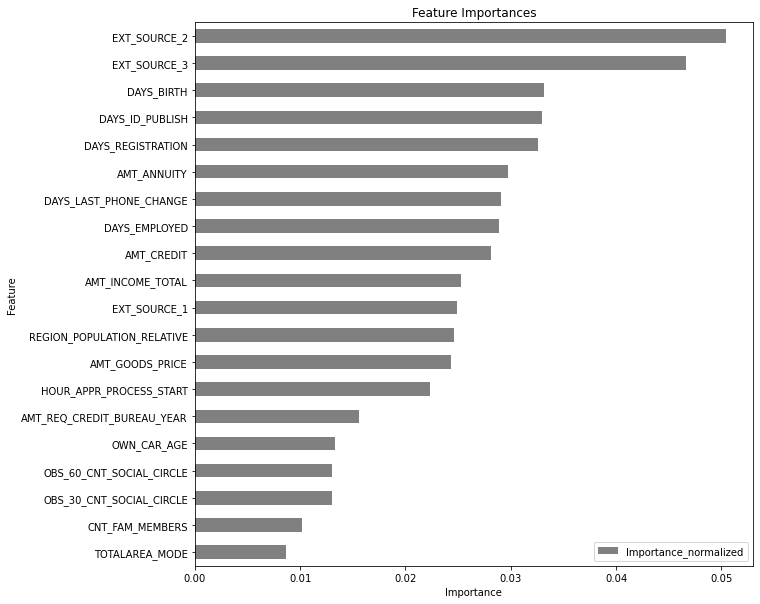

In [39]:
# Function to plot feature importance
def plot_feature_importance(df):

    # Normalize the feature importances to add up to one
    df['Importance_normalized'] = df['Importance'] / df['Importance'].sum()
    df = df.sort_values('Importance_normalized', ascending = True).tail(20)

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 16))

    ax = df.plot(x = 'Feature' , y = 'Importance_normalized', kind = 'barh', figsize=(10,10), color = 'gray')
    
    # Plot labeling
    plt.xlabel('Importance')
    plt.title('Feature Importances')
    plt.show()
    
    # return top 20 features
    return(df['Feature'])

top20 = plot_feature_importance(feature_importances)

OKAY, It was a simple model which we can now improve it by:
   - Enriching the dataset with additional data (Adding Features).
   - Create new features from existing data (Feature Engineering).
   - Tuning Hyperparameters to improve the model performance.

In [40]:
bureau = pd.read_csv("dataset/bureau.csv")

In [41]:
# create feature dataframe
bureau_agg = bureau['SK_ID_CURR'].unique()
bureau_agg = pd.DataFrame(bureau_agg, columns = ['SK_ID_CURR'])
# previous loan count
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()
bureau_agg = bureau_agg.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')
# active loan count
active_loan_counts = bureau[bureau['CREDIT_ACTIVE'] == 'Active'].groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'active_loan_counts'})
active_loan_counts.head()

,SK_ID_CURR,active_loan_counts
0,100001,3
1,100002,2
2,100003,1
3,100005,2
4,100008,1


In [42]:
# join new features
bureau_agg = bureau_agg.merge(active_loan_counts, on = 'SK_ID_CURR', how = 'left')
# fill na
bureau_agg = bureau_agg.fillna(0)

In [43]:
# join additional features onto train and test
train_data_features = train_data.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
test_data_features = test_data.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
train_data_features = train_data_features.fillna(0)
test_data_features = test_data_features.fillna(0)

In [44]:
print('Training data shape: ', train_data_features.shape)
print('Testing data shape: ', test_data_features.shape)

Training data shape:  (307511, 242)
Testing data shape:  (48744, 241)


Training data shape:  (307511, 240)
Testing data shape:  (48744, 240)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   59.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


<Figure size 720x1152 with 0 Axes>

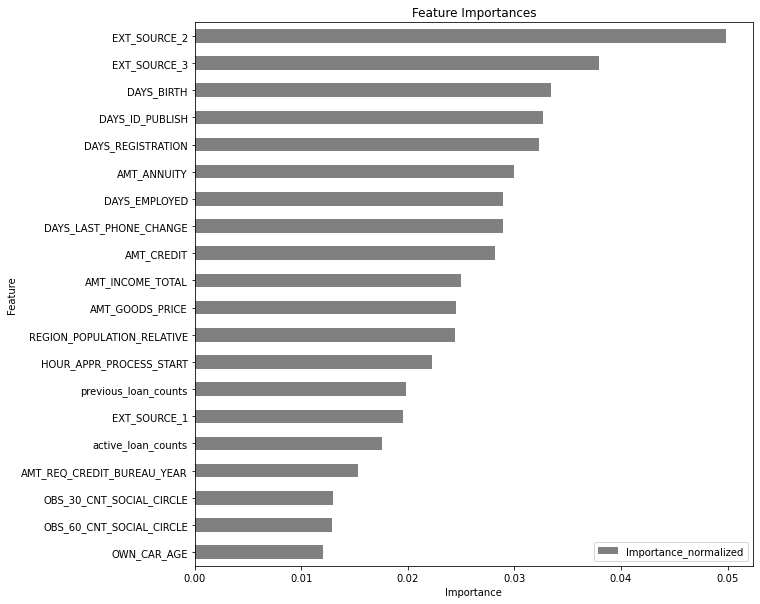

In [45]:
# create X_train, y_train
X_train = train_data_features.drop('TARGET', axis = 1)
y_train = train_data_features['TARGET']
X_test = test_data_features

X_train = X_train.drop('SK_ID_CURR', axis = 1)
X_test = X_test.drop('SK_ID_CURR', axis = 1)

# Feature names
features = list(X_train.columns)

X_train, X_test, test = data_preparation(X_train, X_test)

feature_importances = train_RF_model(X_train, y_train, X_test, features)

top20 = plot_feature_importance(feature_importances)

In [48]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [49]:
submission, fi, metrics = model(train_data_features, test_data_features)
print('Baseline metrics')
print(metrics)

Training Data Shape:  (307511, 240)
Testing Data Shape:  (48744, 240)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.798778	train's binary_logloss: 0.548048	valid's auc: 0.756349	valid's binary_logloss: 0.562904
[400]	train's auc: 0.828526	train's binary_logloss: 0.51835	valid's auc: 0.756394	valid's binary_logloss: 0.544962
Early stopping, best iteration is:
[312]	train's auc: 0.816513	train's binary_logloss: 0.530424	valid's auc: 0.75691	valid's binary_logloss: 0.552258
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.798173	train's binary_logloss: 0.548564	valid's auc: 0.758765	valid's binary_logloss: 0.563616
Early stopping, best iteration is:
[291]	train's auc: 0.812614	train's binary_logloss: 0.534329	valid's auc: 0.759456	valid's binary_logloss: 0.555188
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.797732	train's binary_logloss: 0.549504	valid's auc: 0.763817	valid's binar

In [52]:
def plot_feature_importances(df, num_bars = 15):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """

    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:num_bars]))), 
            df['importance_normalized'].head(num_bars), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:num_bars]))))
    ax.set_yticklabels(df['feature'].head(num_bars))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

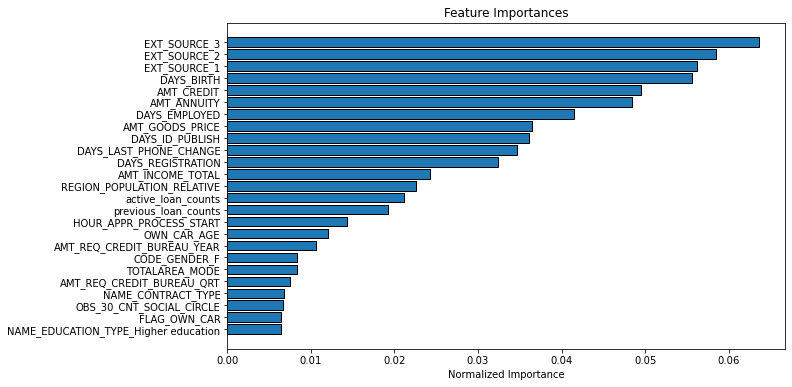

In [53]:
fi_sorted = plot_feature_importances(fi, 25)